In [48]:
# This is the template for the submission. If you want, you can develop your algorithm in a regular Python script and copy the code here for submission.

# Team members (e-mail, legi):
# zhisun@ethz.ch, 22-958-227
# enjcao@ethz.ch, 22-942-700
# yifzhou@ethz.ch, 22-940-381

In [1]:
import pandas as pd
import math
from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset
from os import listdir
from os.path import isfile, join
from math import sqrt
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
# Get the path of all traces
dir_data = 'E:\\Sunzhichao\\ETHz\\2223Spring\\Mobile_Health\\data\\'
dir_traces_train = dir_data + 'train\\'
dir_traces_test = dir_data + 'test\\'
dir_labels = dir_data + 'labels\\'
dir_loaded = dir_data + 'Loaded_data\\'

# recorded
dir_recorded = 'data/recorded'

In [3]:
dir_traces = dir_traces_train
filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f)) and f!='.DS_Store']
filenames.sort()

In [4]:
# key_points
# central
point_central = (8.5441, 47.3768)
# Main building
point_eth = (8.5486, 47.3766)
# P2 End/P3 start
point_wb = (8.5415, 47.3785)
# P4 End
point_coop = (8.5418, 47.3770)
# P1 corner
point_cb = (8.5467, 47.3782)

key_points = [point_central, point_wb, point_coop, point_cb]
key_0      = [1            , 0       , 0         , 0       ]
key_1      = [1            , 0       , 0         , 1       ]
key_23     = [0            , 1       , 0         , 0       ]
key_4      = [1            , 0       , 1         , 0       ]
num_keys = len(key_points)
route_keys = [key_0, key_1, key_23, key_4]


In [73]:
paths = []
mismatch = []
mismatch_id = []
mismatch_gd = []
# wrong: 12 32 33 35
for idx, filename in enumerate(filenames):
# filename = filenames[31]
# print(filename)


    # path index detection algorithm

    # Get the original data from Lilygo -----------------------------------------------------------------------
    # Get gps data
    trace = Recording(filename, no_labels=True, mute=True)
    gps_longitude_original = trace.data['longitude'].values
    gps_latitude_original = trace.data['latitude'].values
    # print('original length: ', len(gps_longitude_original))

    # Get time stamp and sampling rate
    timestamp_raw = trace.data['longitude'].timestamps
    timestamp_ms = timestamp_raw*1000
    sampling_rate = len(timestamp_raw)/timestamp_raw[-1]
    step = 100
    gps_longitude_step = [gps_longitude_original[i] for i in range(0,len(gps_longitude_original), step)]
    gps_latitude_step = [gps_latitude_original[i] for i in range(0,len(gps_longitude_original), step)]
    # print('stepped length: ', len(gps_longitude_step))

    # get distance to key points
    key_path = np.zeros(num_keys)
    max_distance_error = 0.5
    gps_longitude_inrange = []
    gps_latitude_inrange = []
    for i in range(len(gps_longitude_step)):
        for key in key_points:
            distance = np.sqrt((gps_longitude_step[i] - key[0])**2+(gps_latitude_step[i] - key[1])**2)*1000
            if distance < max_distance_error:
                gps_longitude_inrange.append(gps_longitude_step[i])
                gps_latitude_inrange.append(gps_latitude_step[i])
                key_path[key_points.index(key)] = 1

    # predict trace index
    route_key_error = np.zeros(4)
    for i in range(4):
        route_key_error[i] = np.linalg.norm(key_path-route_keys[i], ord=2)
    predicted_path = np.argmin(route_key_error)
    if predicted_path == 3:
        predicted_path = 4
    # distinguish path 2/3
    if predicted_path == 2:
        start_points_longitude = gps_longitude_step[:10]
        start_points_latitude = gps_latitude_step[:10]
        distance_eth = np.sum(np.abs(np.asarray(start_points_longitude)-point_eth[0])+np.abs(np.asarray(start_points_latitude)-point_eth[1]))
        distance_wb = np.sum(np.abs(np.asarray(start_points_longitude)-point_wb[0])+np.abs(np.asarray(start_points_latitude)-point_wb[1]))
        if distance_eth < distance_wb:
            predicted_path = 3
    paths.append(predicted_path)

    if trace.labels['path_idx'] != predicted_path:
        mismatch_id.append(idx)
        mismatch_gd.append(trace.labels['path_idx'])
        mismatch.append(predicted_path)
        print(filename, "ground truth: ", trace.labels['path_idx'], "predicted: ", predicted_path)

        # plot trace
        # Visualize the path of the trace
        fig, ax = plt.subplots(figsize = (12,12))
        ax.scatter(gps_longitude_step, gps_latitude_step, zorder=1, alpha= 0.9, c='b', s=5)
        for point in key_points:
            ax.scatter(point[0], point[1], zorder=1, alpha= 0.3, c='r', s=500)
        BBox = (8.5373,8.5593,
                    47.3673, 47.3880)
        # Load map of Zurich
        ruh_m = plt.imread('mapzurich_labeled.JPG')
        ax.set_title('GPS visualization in Zurich')
        ax.set_xlim(BBox[0],BBox[1])
        ax.set_ylim(BBox[2],BBox[3])
        ax.imshow(ruh_m, zorder=0, extent = BBox)
        fig.savefig('./mismatch_path/'+str(idx+1)+'.png', dpi=300, bbox_inches='tight')




In [7]:
# Write the detected step counts into a .csv file to then upload the .csv file to Kaggle
# When cross-checking the .csv file on your computer, we recommend using the text editor and NOT excel so that the results are displayed correctly
# IMPORTANT: Do NOT change the name of the columns ('Id' and 'Predicted') of the .csv file
df = pd.DataFrame({'Id':mismatch_id,'Predicted':mismatch, 'Ground Truth': mismatch_gd})
df.to_csv('./mismatch_path.csv', index=False)

file:  E:\Sunzhichao\ETHz\2223Spring\Mobile_Health\data\train\train_trace_262.json idx:  261 raw:  3 predicted:  0


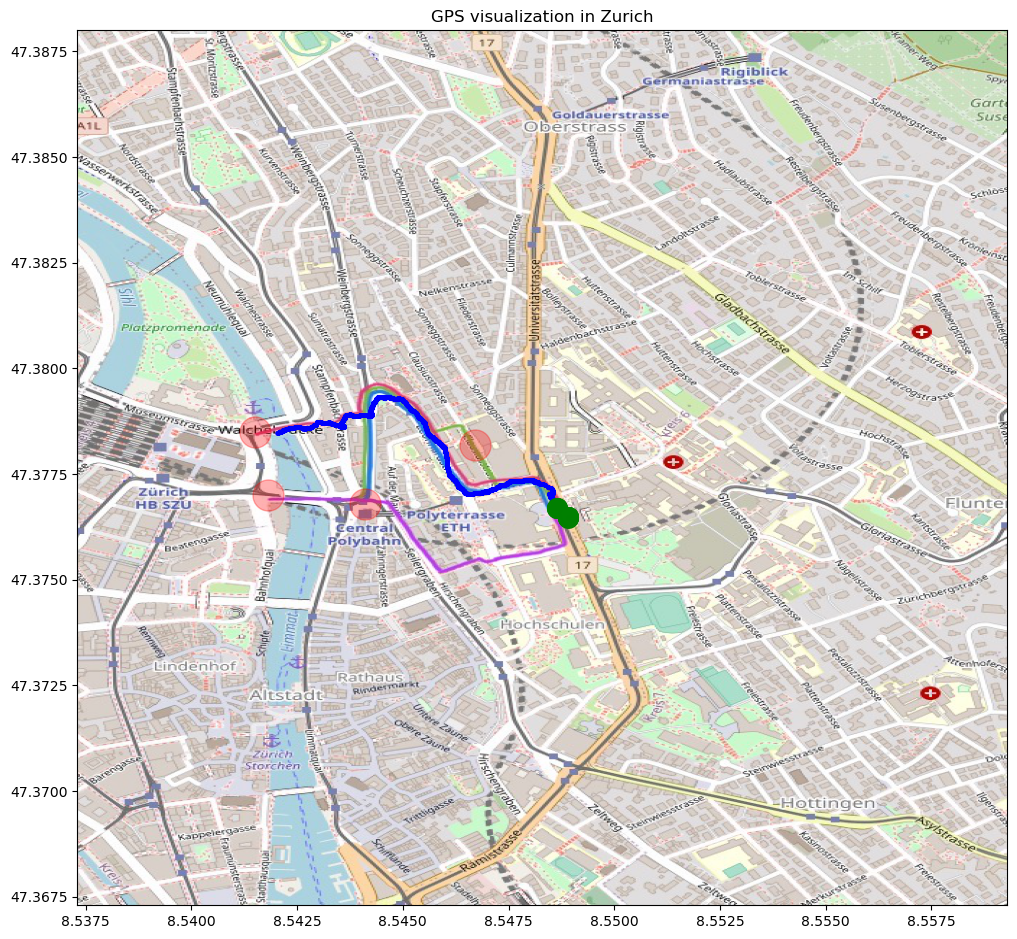

In [72]:
i = 45
filename = filenames[mismatch_id[i]]
print("file: ", filename, "idx: ", mismatch_id[i], "raw: ", mismatch_gd[i], "predicted: ", mismatch[i])
# print(filename)
trace = Recording(filename, no_labels=True, mute=True)
gps_longitude_original = trace.data['longitude'].values
gps_latitude_original = trace.data['latitude'].values
# print('original length: ', len(gps_longitude_original))

# Get time stamp and sampling rate
timestamp_raw = trace.data['longitude'].timestamps
timestamp_ms = timestamp_raw*1000
sampling_rate = len(timestamp_raw)/timestamp_raw[-1]
# plot trace
# Visualize the path of the trace
fig, ax = plt.subplots(figsize = (12,12))

ax.scatter(gps_longitude_original, gps_latitude_original, zorder=1, alpha= 0.9, c='b', s=5)
ax.scatter(gps_longitude_original[:10], gps_latitude_original[:10], zorder=1, alpha= 0.9, c='g', s=200)
for point in key_points:
    ax.scatter(point[0], point[1], zorder=1, alpha= 0.3, c='r', s=500)
BBox = (8.5373,8.5593,
            47.3673, 47.3880)
# Load map of Zurich
ruh_m = plt.imread('mapzurich_labeled.JPG')
ax.set_title('GPS visualization in Zurich')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox)

In [80]:
# correct mislabels
raw_labels = np.load(dir_loaded+"train_path_label.npy")
df_mismatch = pd.read_csv('mismatch_path.csv')
id = df_mismatch['Id'].tolist()
true_label = df_mismatch['Predicted'].tolist()
mis_label = df_mismatch['Ground Truth'].tolist()
for i in range(len(id)):
    if(raw_labels[id[i]] == mis_label[i]):
        print("found mis label in ", id[i]+1)
        raw_labels[id[i]] = true_label[i]

raw_labels = np.save(dir_loaded+"train_path_label_corrected.npy", raw_labels)

found mis label in  30
found mis label in  51
found mis label in  58
found mis label in  98
found mis label in  99
found mis label in  121
